In [2]:
# Imports
import torch
import matplotlib.pyplot as plt
import torchvision
import torch.nn.functional as F 
from torch import nn 
import torchvision.datasets as datasets
from torch.utils.data import Dataset 
from torch.utils.data import random_split 
import torchvision.transforms as transforms 
import os
import shutil
import numpy as np
import pandas as pd
from torchvision.io import read_image
from torch import optim
from torch.utils.data import DataLoader, ConcatDataset
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from tqdm import tqdm 
from sklearn import metrics

from utils.dataGen import Patches
from ResNet.ResNet import ResNet as CNN
from PIL import Image
import spectral as spec

In [3]:
# Set device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.device_count()

1

In [3]:
# Hyperparameters

in_channels = 3
classes = ["background", "leaf", "diseased"]
num_classes = len(classes)
weights = [1.0, 1.0, 1.0]
rgb_bands = [0, 1, 2]
img_size = 100
learning_rate = 0.01
batch_size = 32
num_epochs = 100
frac = .7

In [4]:
# Custom image dataset

class Img(Dataset):
    def __init__(self, img_df, transform=None):
        self.img_df = img_df
        self.transform = transform

    def __len__(self):
        return len(self.img_df)

    def __getitem__(self, idx):
        img_path = self.img_df['path'].iloc[idx]
        img = spec.envi.open(img_path)
        np_img = np.array(img[:, :, :])
        label = self.img_df['class'].iloc[idx]
        if self.transform:
            image = self.transform(np_img)
        return image, label

In [5]:
def tensorToImg(tensor, img_size):
    img = torch.zeros(img_size, img_size, len(rgb_bands))
    for i, b in enumerate(rgb_bands):
        img[:,:,b] = tensor[i]
    return img

In [6]:
def displayImgs(imgs, labels, img_size, n=batch_size, save=False):
    fig = plt.figure(figsize=(20,11))
    for i, img in enumerate(imgs[:n]):
        img = tensorToImg(img, img_size)
        fig.add_subplot(4, 8, i + 1).title.set_text(classes[labels[i]])
        plt.imshow(img)
    plt.subplots_adjust(wspace=0.2)
    plt.show()
    if save:
        fig.savefig('fig.png')

In [7]:
# Transformers
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((img_size, img_size)),
    transforms.ConvertImageDtype(torch.float)])

In [8]:
patch_25 = Patches("D:\\gys_22_10_28_rgb\\PATCHES")

In [9]:
print(patch_25.describe())

For hdr image, there are: 
 background    1037
leaf           797
diseased       104
Name: class, dtype: int64
For jpg image, there are: 
 background    1037
leaf           797
diseased       104
Name: class, dtype: int64
None


In [10]:
def getDataset(patch, dc, train_frac = .7, data_type='hdr'):
    patch_ds = patch.generateAndSplitDataset(
        dataset_composition = [[classes[i], dc[i]] for i in range(len(classes))],
        data_type = data_type,
        train_frac = train_frac)
    for pn, p in enumerate(patch_ds):
        for i, c in enumerate(classes):
             p.loc[(p['class'] == c), 'class'] = i
                
        print(p.describe())
    
    return patch_ds

In [11]:
patch_ds = [getDataset(patch_25, [700, 700, 104])]

                                                     path  type  class
count                                                1053  1053   1053
unique                                               1053     1      3
top     D:\gys_22_10_28_rgb\PATCHES\gys_22_10_28_1\hdr...   hdr      0
freq                                                    1  1053    490
                                                     path type  class
count                                                 451  451    451
unique                                                451    1      3
top     D:\gys_22_10_28_rgb\PATCHES\gys_22_10_28_1\hdr...  hdr      0
freq                                                    1  451    210


In [12]:
train_patch = pd.concat([ds[0] for ds in patch_ds])
val_patch = pd.concat([ds[1] for ds in patch_ds])

In [13]:
def transformDs(patch, n=1):
    ds = []
    for i in range(n):
        ds.append(Img(img_df=patch, 
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize((img_size, img_size)),
                        transforms.RandomRotation(degrees=(int(360/(n + 1)) * (i + 1))),
                        transforms.ConvertImageDtype(torch.float)])
                     )
                 )
        
    return ds

In [14]:
def augmentPatch(patch, aug_com, n):
    patch_ds_list = [[],[]]
    dataset = [[],[]]
    for i in range(len(aug_com)):
        patch_ds_c = getDataset(patch, [aug_com[i] if i2 == i else 0 for i2 in range(num_classes)])
        for i2 in range(2):
            patch_ds_list[i2].append(patch_ds_c[i2])
            dataset_c = transformDs(patch_ds_c[i2], n[i])
            for dc in dataset_c:
                dataset[i2].append(dc)
                
    return dataset, patch_ds_list

In [15]:
patch_ds_aug_25, patch_25_aug_list = augmentPatch(patch_25, [200, 200, 104], [1, 1, 8])

                                                     path type  class
count                                                 140  140    140
unique                                                140    1      1
top     D:\gys_22_10_28_rgb\PATCHES\gys_22_10_28_1\hdr...  hdr      0
freq                                                    1  140    140
                                                     path type  class
count                                                  60   60     60
unique                                                 60    1      1
top     D:\gys_22_10_28_rgb\PATCHES\gys_22_10_28_1\hdr...  hdr      0
freq                                                    1   60     60
                                                     path type  class
count                                                 140  140    140
unique                                                140    1      1
top     D:\gys_22_10_28_rgb\PATCHES\gys_22_10_28_1\hdr...  hdr      1
freq                

In [16]:
def countDs(ds):
    c = {c:0 for c in classes}
    for d in ds:
        c[classes[d[1]]] += 1
    return c

In [17]:
train_dataset = Img(img_df=train_patch, transform=img_transform)
val_dataset = Img(img_df=val_patch, transform=img_transform)

train_dataset = ConcatDataset([train_dataset] + patch_ds_aug_25[0])
val_dataset = ConcatDataset([val_dataset] + patch_ds_aug_25[1])

print(f"The num of training dataset is {len(train_dataset)} and num of validation dataset is {len(val_dataset)}")
print(countDs(train_dataset), countDs(val_dataset))

The num of training dataset is 1917 and num of validation dataset is 819
{'background': 630, 'leaf': 630, 'diseased': 657} {'background': 270, 'leaf': 270, 'diseased': 279}


In [43]:
for d, n in zip([train_patch, val_patch, pd.concat(patch_25_aug_list[0]), pd.concat(patch_25_aug_list[1])],
             ["train.csv", "val.csv", "aug_train.csv", "aug_val.csv"]):
    d.to_csv(n)

In [19]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

In [20]:
next(iter(train_loader))[0].shape

torch.Size([32, 3, 100, 100])

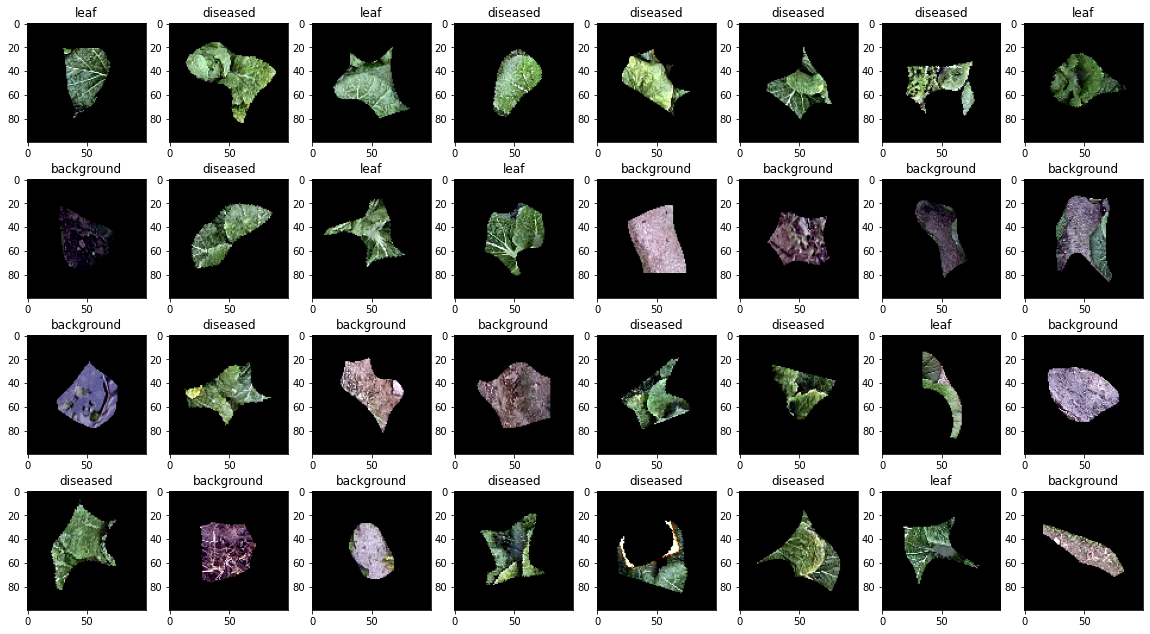

In [21]:
# Check the images
for train_batch in train_loader:
    displayImgs(train_batch[0], train_batch[1], img_size, save=False)
    break

In [22]:
# Initialize network

model = CNN(in_channels=in_channels, num_classes=len(classes)).to(device)
print("Num of trainable param:", sum(p.numel() for p in model.parameters() if p.requires_grad))

22266115

In [23]:
# Loss and optimizer

class_weights = torch.FloatTensor(weights).cuda()
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

In [24]:
# Check the model

with torch.no_grad():
    for x, y in train_loader:
        x = x.to(device=device)
        y = y.to(device=device)
        x_ = model(x)
        print(x_[0])
        break

tensor([-0.3105, -0.1633, -0.8622], device='cuda:0')


In [25]:
# Check accuracy on training & test to see how good our model

def evaluate(loader, model):
    ev = np.zeros(5 + len(classes))
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
                        
            y = y.cpu()
            predictions = predictions.cpu()
                        
            ev[0] += 1
            ev[1] += precision_score(y, predictions, average='micro')
            ev[2] += recall_score(y, predictions, average='micro')
            ev[3] += f1_score(y, predictions, average='micro')
            ev[4] += accuracy_score(y, predictions)
                        
            confusion_matrix = metrics.confusion_matrix(y, predictions)                        
            sum_ax1 = confusion_matrix.sum(axis=1)
            for i in range(len(sum_ax1)):
                ev[5 + i] += 0
                if sum_ax1[i] != 0:
                    res = confusion_matrix[i].astype('float') / sum_ax1[i]
                    ev[5 + i] += res[i]
            
        ev = ev/ev[0]
        
    model.train()
    return ev*100

print(f"Accuracy on training set \n: {evaluate(train_loader, model)}")
print(f"Accuracy on test set \n: {evaluate(test_loader, model)}")

Accuracy on training set 
: [100.          28.16810345  28.16810345  28.16810345  28.16810345
  54.07239751  12.78614441  17.03968485]
Accuracy on test set 
: [100.          27.57464575  27.57464575  27.57464575  27.57464575
  50.74517897  10.63972133  21.05040761]


In [26]:
# Make a list to record training progress

history_test = [[] for l in range(6 + num_classes)]
history_train = [[] for l in range(6 + num_classes)]
highest_diseases = 0

In [27]:
# Train the network

for epoch in range(num_epochs):
    batch_loss = np.array([])
    loop = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (data, targets) in loop:
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
        predictions = torch.argmax(scores, dim=1)
               
        #update progess bar
        loop.set_description(f"Epoch[{epoch}/{num_epochs - 1}]")
        
        batch_loss = np.append(batch_loss, loss.item())
    
    scheduler.step()
    
    history_train[5 + num_classes].append(np.average(batch_loss))
    evaluation_test = evaluate(test_loader, model)
    evaluation_train = evaluate(train_loader, model)
    for i in range(5 + num_classes):
        history_test[i].append(evaluation_test[i])
        history_train[i].append(evaluation_train[i])
    
    if history_test[7][-1] > highest_diseases and \
       history_train[7][-1] > highest_diseases and \
       history_test[6][-1] >= 80:
        highest_diseases = history_test[7][-1]
        torch.save(model.state_dict(), os.getcwd() + f"\\ResNet_rgb_25_노균병_best.pt")
        print(f"Best is on {epoch} epoch") 
    
    print(optimizer.param_groups[0]['lr'])    
    print(f""" 
         loss      : {history_train[5 + num_classes][-1]}
         precision : {history_test[1][-1]} 
         recall    : {history_test[2][-1]}
         f1 score  : {history_test[3][-1]}
         accuracy  : {history_test[4][-1]} \n""")
    
    for i in range(num_classes):
        print(f"accuracy_{i}: {history_test[5 + i][-1]}, {history_train[5 + i][-1]}")

Epoch[0/99]: 100%|█████████████████████████████████████████████████████████████████████| 60/60 [00:23<00:00,  2.51it/s]


0.01
 
         loss      : 124.81302276452382
         precision : 68.17434210526316 
         recall    : 68.17434210526316
         f1 score  : 68.17434210526316
         accuracy  : 68.17434210526316 

accuracy_0: 91.89673574288959, 92.71428108928104
accuracy_1: 53.37755193524424, 55.905677791707184
accuracy_2: 58.06762681762682, 47.55396319366907


Epoch[1/99]: 100%|█████████████████████████████████████████████████████████████████████| 60/60 [00:25<00:00,  2.35it/s]


0.01
 
         loss      : 5.107633817195892
         precision : 73.27302631578948 
         recall    : 73.27302631578948
         f1 score  : 73.27302631578948
         accuracy  : 73.27302631578948 

accuracy_0: 94.90464663541587, 97.00558469308469
accuracy_1: 36.19477210823364, 39.36715599215599
accuracy_2: 89.26541407310637, 90.84707653457652


Epoch[2/99]: 100%|█████████████████████████████████████████████████████████████████████| 60/60 [00:20<00:00,  2.93it/s]


0.01
 
         loss      : 6.150911184151967
         precision : 64.29023279352228 
         recall    : 64.29023279352228
         f1 score  : 64.29023279352228
         accuracy  : 64.29023279352228 

accuracy_0: 95.92209072978305, 98.13805339540632
accuracy_1: 75.13394724933187, 80.16511729011727
accuracy_2: 23.988426103810724, 31.84087209087209


Epoch[3/99]: 100%|█████████████████████████████████████████████████████████████████████| 60/60 [00:20<00:00,  2.93it/s]


0.01
 
         loss      : 1.6377995828787486
         precision : 73.78542510121459 
         recall    : 73.78542510121459
         f1 score  : 73.78542510121459
         accuracy  : 73.78542510121459 

accuracy_0: 93.36238547777008, 96.56314287564285
accuracy_1: 65.97767616998387, 71.18488279150044
accuracy_2: 62.490089724252606, 77.85376660376659


Epoch[4/99]: 100%|█████████████████████████████████████████████████████████████████████| 60/60 [00:19<00:00,  3.08it/s]


Best is on 4 epoch
0.01
 
         loss      : 1.3861418864379327
         precision : 65.68825910931173 
         recall    : 65.68825910931173
         f1 score  : 65.68825910931173
         accuracy  : 65.68825910931173 

accuracy_0: 86.55480203557127, 88.87251406001401
accuracy_1: 96.38786270290794, 96.65455609205608
accuracy_2: 16.661482057409657, 20.312527205909557


Epoch[5/99]: 100%|█████████████████████████████████████████████████████████████████████| 60/60 [00:19<00:00,  3.03it/s]


0.01
 
         loss      : 1.2730451432367167
         precision : 76.63841093117409 
         recall    : 76.63841093117409
         f1 score  : 76.63841093117409
         accuracy  : 76.63841093117409 

accuracy_0: 90.55755142293603, 95.70177834148423
accuracy_1: 49.76060641219013, 61.04646497293557
accuracy_2: 88.20720945720947, 94.56127206127205


Epoch[6/99]: 100%|█████████████████████████████████████████████████████████████████████| 60/60 [00:19<00:00,  3.13it/s]


0.01
 
         loss      : 0.8335828886677822
         precision : 74.8292004048583 
         recall    : 74.8292004048583
         f1 score  : 74.8292004048583
         accuracy  : 74.8292004048583 

accuracy_0: 97.46668772404067, 99.64814814814814
accuracy_1: 58.11140782294628, 69.62651754563521
accuracy_2: 69.55791003867927, 81.81814713064708


Epoch[7/99]: 100%|█████████████████████████████████████████████████████████████████████| 60/60 [00:19<00:00,  3.10it/s]


0.01
 
         loss      : 0.8490156362454097
         precision : 73.86133603238866 
         recall    : 73.86133603238866
         f1 score  : 73.86133603238866
         accuracy  : 73.86133603238866 

accuracy_0: 91.65139881486036, 95.882696007696
accuracy_1: 33.881332342870806, 39.51289097612626
accuracy_2: 97.02734765234766, 99.09798534798534


Epoch[8/99]: 100%|█████████████████████████████████████████████████████████████████████| 60/60 [00:19<00:00,  3.12it/s]


0.01
 
         loss      : 0.8828092650820811
         precision : 76.79023279352228 
         recall    : 76.79023279352228
         f1 score  : 76.79023279352228
         accuracy  : 76.79023279352228 

accuracy_0: 86.07213299520991, 93.60029955424689
accuracy_1: 53.127758993143615, 64.29349816849819
accuracy_2: 90.54002621310313, 97.53311136031722


Epoch[9/99]: 100%|█████████████████████████████████████████████████████████████████████| 60/60 [00:19<00:00,  3.14it/s]


0.01
 
         loss      : 0.7237229918440183
         precision : 76.46761133603239 
         recall    : 76.46761133603239
         f1 score  : 76.46761133603239
         accuracy  : 76.46761133603239 

accuracy_0: 91.88769563769564, 96.74540043290042
accuracy_1: 41.192354653893105, 55.855024605024596
accuracy_2: 95.21793377562608, 100.0


Epoch[10/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:19<00:00,  3.14it/s]


Best is on 10 epoch
0.01
 
         loss      : 0.490577340995272
         precision : 72.10905870445343 
         recall    : 72.10905870445343
         f1 score  : 72.10905870445343
         accuracy  : 72.10905870445343 

accuracy_0: 92.56443342981805, 98.15993265993264
accuracy_1: 94.44416694416695, 98.48803511303508
accuracy_2: 28.564074814074814, 44.40192446442447


Epoch[11/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:19<00:00,  3.03it/s]


0.01
 
         loss      : 0.42451251366486153
         precision : 81.28162955465588 
         recall    : 81.28162955465588
         f1 score  : 81.28162955465588
         accuracy  : 81.28162955465588 

accuracy_0: 91.9679839391378, 98.02812465312464
accuracy_1: 63.44018600805931, 72.44298063048062
accuracy_2: 85.77451394759088, 95.55973047420412


Epoch[12/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:16<00:00,  3.63it/s]


0.01
 
         loss      : 0.5109586667269468
         precision : 81.28795546558703 
         recall    : 81.28795546558703
         f1 score  : 81.28795546558703
         accuracy  : 81.28795546558703 

accuracy_0: 96.81915306915309, 99.33475783475782
accuracy_1: 57.25356908049215, 72.47614735482382
accuracy_2: 88.81186121570738, 97.86066112536699


Epoch[13/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:16<00:00,  3.57it/s]


0.01
 
         loss      : 0.4978463144352039
         precision : 71.69787449392712 
         recall    : 71.69787449392712
         f1 score  : 71.69787449392712
         accuracy  : 71.69787449392712 

accuracy_0: 93.08985352254582, 98.53259240759242
accuracy_1: 23.74257686757687, 31.598433973433966
accuracy_2: 98.87734814205402, 99.52777777777777


Epoch[14/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:16<00:00,  3.56it/s]


Best is on 14 epoch
0.01
 
         loss      : 0.35706982370465995
         precision : 80.68066801619433 
         recall    : 80.68066801619433
         f1 score  : 80.68066801619433
         accuracy  : 80.68066801619433 

accuracy_0: 93.92496392496393, 97.79042716542716
accuracy_1: 80.73562121639046, 93.73588679838676
accuracy_2: 69.40628815628814, 85.75692063927359


Epoch[15/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:17<00:00,  3.41it/s]


0.01
 
         loss      : 0.3237561123756071
         precision : 77.91624493927127 
         recall    : 77.91624493927127
         f1 score  : 77.91624493927127
         accuracy  : 77.91624493927127 

accuracy_0: 90.78215587830972, 96.3890394735983
accuracy_1: 89.9126834703758, 96.83880933880931
accuracy_2: 55.434588036398004, 74.05638574388574


Epoch[16/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:16<00:00,  3.56it/s]


0.01
 
         loss      : 0.3247673954193791
         precision : 81.32591093117409 
         recall    : 81.32591093117409
         f1 score  : 81.32591093117409
         accuracy  : 81.32591093117409 

accuracy_0: 93.20245993322918, 98.6144411144411
accuracy_1: 67.86740785609564, 84.22170653420655
accuracy_2: 82.22902097902097, 96.31937506937506


Epoch[17/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:16<00:00,  3.55it/s]


0.01
 
         loss      : 0.2332635105897983
         precision : 83.48937246963563 
         recall    : 83.48937246963563
         f1 score  : 83.48937246963563
         accuracy  : 83.48937246963563 

accuracy_0: 97.21239764508994, 99.75274725274726
accuracy_1: 63.29826156749233, 83.29337519778694
accuracy_2: 89.30721522067677, 97.8906857031857


Epoch[18/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:16<00:00,  3.55it/s]


0.01
 
         loss      : 0.6785924253364404
         precision : 78.68168016194332 
         recall    : 78.68168016194332
         f1 score  : 78.68168016194332
         accuracy  : 78.68168016194332 

accuracy_0: 85.15314813391738, 85.5556526806527
accuracy_1: 58.353281334050564, 74.43999314955198
accuracy_2: 92.38724950263412, 98.89911477411476


Epoch[19/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:16<00:00,  3.55it/s]


Best is on 19 epoch
0.01
 
         loss      : 0.8015339023744067
         precision : 81.40814777327935 
         recall    : 81.40814777327935
         f1 score  : 81.40814777327935
         accuracy  : 81.40814777327935 

accuracy_0: 92.55018485787717, 98.11545793531084
accuracy_1: 80.93886882348419, 93.0353026603026
accuracy_2: 71.67948504486968, 87.91242553742555


Epoch[20/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:17<00:00,  3.37it/s]


0.01
 
         loss      : 0.39609523651500544
         precision : 80.51619433198381 
         recall    : 80.51619433198381
         f1 score  : 80.51619433198381
         accuracy  : 80.51619433198381 

accuracy_0: 91.26790944098637, 97.28924778924777
accuracy_1: 56.07221304336688, 72.33537064787066
accuracy_2: 93.11750968990788, 99.07407407407408


Epoch[21/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:16<00:00,  3.61it/s]


0.01
 
         loss      : 0.39211703687906263
         precision : 81.84463562753037 
         recall    : 81.84463562753037
         f1 score  : 81.84463562753037
         accuracy  : 81.84463562753037 

accuracy_0: 95.90706302244763, 98.0823828948829
accuracy_1: 78.980817448012, 93.07579090299676
accuracy_2: 71.2839831109062, 92.74752494237788


Epoch[22/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:16<00:00,  3.65it/s]


0.01
 
         loss      : 0.23309800755232574
         precision : 82.61007085020242 
         recall    : 82.61007085020242
         f1 score  : 82.61007085020242
         accuracy  : 82.61007085020242 

accuracy_0: 95.97699309237771, 99.00328837828839
accuracy_1: 66.2524761563223, 90.35611927059293
accuracy_2: 83.95161462469157, 97.70124320124319


Epoch[23/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:15<00:00,  3.80it/s]


0.01
 
         loss      : 0.19539892071237167
         precision : 83.28694331983806 
         recall    : 83.28694331983806
         f1 score  : 83.28694331983806
         accuracy  : 83.28694331983806 

accuracy_0: 94.01080756849989, 99.2277985172722
accuracy_1: 85.60344569959955, 96.1398555148555
accuracy_2: 70.47121681737065, 91.82150583621168


Epoch[24/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:15<00:00,  3.77it/s]


0.001
 
         loss      : 0.23698047418923426
         precision : 81.12348178137651 
         recall    : 81.12348178137651
         f1 score  : 81.12348178137651
         accuracy  : 81.12348178137651 

accuracy_0: 91.15908663985586, 96.17495698745698
accuracy_1: 59.145469914700676, 80.28560219736688
accuracy_2: 93.9690704594551, 99.59848484848483


Epoch[25/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:16<00:00,  3.55it/s]


0.001
 
         loss      : 0.17118463469669223
         precision : 81.68016194331985 
         recall    : 81.68016194331985
         f1 score  : 81.68016194331985
         accuracy  : 81.68016194331985 

accuracy_0: 94.71589308127768, 98.90420227920225
accuracy_1: 83.14099362176285, 94.49207505457504
accuracy_2: 65.33331518908442, 93.99166669387252


Epoch[26/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:18<00:00,  3.24it/s]


Best is on 26 epoch
0.001
 
         loss      : 0.12869101113950213
         precision : 84.65334008097165 
         recall    : 84.65334008097165
         f1 score  : 84.65334008097165
         accuracy  : 84.65334008097165 

accuracy_0: 95.47702297702297, 99.5054945054945
accuracy_1: 80.5846877481493, 94.68579106079102
accuracy_2: 78.29127069511685, 97.58584634319928


Epoch[27/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:18<00:00,  3.33it/s]


0.001
 
         loss      : 0.14133180323988198
         precision : 84.97596153846155 
         recall    : 84.97596153846155
         f1 score  : 84.97596153846155
         accuracy  : 84.97596153846155 

accuracy_0: 96.60817477619096, 99.68660968660967
accuracy_1: 82.2990722198867, 92.21877060847648
accuracy_2: 76.26240212778677, 95.82461982461979


Epoch[28/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:17<00:00,  3.52it/s]


0.001
 
         loss      : 0.1385116696668168
         precision : 82.35703441295547 
         recall    : 82.35703441295547
         f1 score  : 82.35703441295547
         accuracy  : 82.35703441295547 

accuracy_0: 95.33444119982583, 99.50925925925927
accuracy_1: 82.41598522141508, 95.5494042994043
accuracy_2: 68.30769783258471, 93.44659507159506


Epoch[29/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:17<00:00,  3.52it/s]


0.001
 
         loss      : 0.12703294083476066
         precision : 84.40662955465588 
         recall    : 84.40662955465588
         f1 score  : 84.40662955465588
         accuracy  : 84.40662955465588 

accuracy_0: 96.6008991008991, 99.45512820512819
accuracy_1: 77.32510136921904, 92.92125630360921
accuracy_2: 80.34762246300708, 98.72490934990934


Epoch[30/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:17<00:00,  3.52it/s]


Best is on 30 epoch
0.001
 
         loss      : 0.13759596220528086
         precision : 86.1336032388664 
         recall    : 86.1336032388664
         f1 score  : 86.1336032388664
         accuracy  : 86.1336032388664 

accuracy_0: 94.98751248751248, 99.73737373737373
accuracy_1: 80.02661868046484, 94.75313575313571
accuracy_2: 83.1547192124115, 97.46168183668183


Epoch[31/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:17<00:00,  3.37it/s]


0.001
 
         loss      : 0.11330200261436403
         precision : 84.24215587044534 
         recall    : 84.24215587044534
         f1 score  : 84.24215587044534
         accuracy  : 84.24215587044534 

accuracy_0: 97.05024142524142, 99.44250194250193
accuracy_1: 81.84844002151695, 94.46412846412844
accuracy_2: 75.69258732720272, 97.19511670246963


Epoch[32/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:16<00:00,  3.54it/s]


0.001
 
         loss      : 0.12786748741442958
         precision : 84.7672064777328 
         recall    : 84.7672064777328
         f1 score  : 84.7672064777328
         accuracy  : 84.7672064777328 

accuracy_0: 96.16921916695674, 99.27583527583526
accuracy_1: 82.6580364080364, 95.62507726478312
accuracy_2: 76.87456156079637, 97.32858345358345


Epoch[33/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:16<00:00,  3.59it/s]


0.001
 
         loss      : 0.11434289201473197
         precision : 84.44458502024291 
         recall    : 84.44458502024291
         f1 score  : 84.44458502024291
         accuracy  : 84.44458502024291 

accuracy_0: 96.12942612942615, 99.58333333333333
accuracy_1: 82.94749840802473, 96.32846252331544
accuracy_2: 74.6340571821341, 96.14411976911974


Epoch[34/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:16<00:00,  3.56it/s]


0.001
 
         loss      : 0.10942549764489135
         precision : 83.9321862348178 
         recall    : 83.9321862348178
         f1 score  : 83.9321862348178
         accuracy  : 83.9321862348178 

accuracy_0: 96.33464825772519, 99.89583333333333
accuracy_1: 81.23599690907383, 95.6563783438783
accuracy_2: 75.72445999199392, 96.92290579790578


Epoch[35/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:16<00:00,  3.57it/s]


0.001
 
         loss      : 0.1102706069747607
         precision : 84.0080971659919 
         recall    : 84.0080971659919
         f1 score  : 84.0080971659919
         accuracy  : 84.0080971659919 

accuracy_0: 95.87612174150635, 99.29761904761905
accuracy_1: 77.88155220847528, 94.15478965478961
accuracy_2: 78.18362256145063, 99.31944444444444


Epoch[36/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:16<00:00,  3.61it/s]


0.001
 
         loss      : 0.10199358242874344
         precision : 84.09033400809717 
         recall    : 84.09033400809717
         f1 score  : 84.09033400809717
         accuracy  : 84.09033400809717 

accuracy_0: 96.17188367188366, 99.65277777777779
accuracy_1: 87.11526721142104, 95.44348244348242
accuracy_2: 70.83261792255006, 92.41301522551521


Epoch[37/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:17<00:00,  3.50it/s]


0.001
 
         loss      : 0.10862726719739536
         precision : 84.05237854251013 
         recall    : 84.05237854251013
         f1 score  : 84.05237854251013
         accuracy  : 84.05237854251013 

accuracy_0: 96.27412651451112, 99.27248677248677
accuracy_1: 82.21077533577534, 94.72120009620009
accuracy_2: 75.2568478530017, 97.16127486348073


Epoch[38/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:17<00:00,  3.51it/s]


0.001
 
         loss      : 0.0916432017305245
         precision : 83.97014170040487 
         recall    : 83.97014170040487
         f1 score  : 83.97014170040487
         accuracy  : 83.97014170040487 

accuracy_0: 95.35289496827957, 99.22486772486772
accuracy_1: 81.5739602278064, 96.4401686276686
accuracy_2: 75.94169719169719, 96.75300625300623


Epoch[39/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:17<00:00,  3.47it/s]


0.001
 
         loss      : 0.09852830795571207
         precision : 84.7672064777328 
         recall    : 84.7672064777328
         f1 score  : 84.7672064777328
         accuracy  : 84.7672064777328 

accuracy_0: 96.28343878343878, 99.70959595959596
accuracy_1: 83.33227669766133, 96.30248155983448
accuracy_2: 75.10792626177243, 97.21459096459094


Epoch[40/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:17<00:00,  3.49it/s]


0.001
 
         loss      : 0.10100235636346042
         precision : 83.28694331983806 
         recall    : 83.28694331983806
         f1 score  : 83.28694331983806
         accuracy  : 83.28694331983806 

accuracy_0: 95.79856041394504, 99.46759259259258
accuracy_1: 86.81999624307318, 96.68227007197594
accuracy_2: 65.32069959954576, 92.43494631729924


Epoch[41/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:17<00:00,  3.51it/s]


0.001
 
         loss      : 0.1267596253659576
         precision : 86.0576923076923 
         recall    : 86.0576923076923
         f1 score  : 86.0576923076923
         accuracy  : 86.0576923076923 

accuracy_0: 96.51843882613113, 99.58139083139082
accuracy_1: 78.33930015104103, 94.97052947052946
accuracy_2: 81.3245515168592, 98.51002238502237


Epoch[42/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:17<00:00,  3.49it/s]


0.001
 
         loss      : 0.08971769243168334
         precision : 85.33021255060729 
         recall    : 85.33021255060729
         f1 score  : 85.33021255060729
         accuracy  : 85.33021255060729 

accuracy_0: 96.72513384051845, 99.6103896103896
accuracy_1: 87.78291153291154, 96.51016113516113
accuracy_2: 71.15926808234501, 95.12450145170732


Epoch[43/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:19<00:00,  3.10it/s]


0.001
 
         loss      : 0.08433782417948048
         precision : 85.17206477732793 
         recall    : 85.17206477732793
         f1 score  : 85.17206477732793
         accuracy  : 85.17206477732793 

accuracy_0: 96.71002608502609, 99.66666666666666
accuracy_1: 81.71094616795975, 94.41418072668071
accuracy_2: 76.86792907946754, 98.19767269767267


Epoch[44/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:18<00:00,  3.29it/s]


0.001
 
         loss      : 0.0972075768513605
         precision : 85.17206477732793 
         recall    : 85.17206477732793
         f1 score  : 85.17206477732793
         accuracy  : 85.17206477732793 

accuracy_0: 96.87257187257187, 99.42520442520443
accuracy_1: 82.07908544447005, 95.72218522218516
accuracy_2: 77.16114014190939, 97.9447913197913


Epoch[45/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:17<00:00,  3.35it/s]


0.001
 
         loss      : 0.10940569379987816
         precision : 86.01341093117409 
         recall    : 86.01341093117409
         f1 score  : 86.01341093117409
         accuracy  : 86.01341093117409 

accuracy_0: 96.49772236310697, 99.8888888888889
accuracy_1: 76.2636081866851, 94.62851500351496
accuracy_2: 84.73616127462282, 99.27441077441075


Epoch[46/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:17<00:00,  3.37it/s]


0.001
 
         loss      : 0.0869054561946541
         precision : 83.48937246963563 
         recall    : 83.48937246963563
         f1 score  : 83.48937246963563
         accuracy  : 83.48937246963563 

accuracy_0: 96.17655848425079, 99.41842185592186
accuracy_1: 85.1507733719272, 97.26050338550336
accuracy_2: 69.53588078588079, 95.79793123543118


Epoch[47/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:17<00:00,  3.39it/s]


0.001
 
         loss      : 0.10515570978168398
         precision : 82.76821862348179 
         recall    : 82.76821862348179
         f1 score  : 82.76821862348179
         accuracy  : 82.76821862348179 

accuracy_0: 97.17476967476966, 99.83333333333333
accuracy_1: 86.32921031959495, 98.62799564270152
accuracy_2: 63.89363841286918, 87.78424815924815


Epoch[48/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:17<00:00,  3.38it/s]


0.001
 
         loss      : 0.08789327714281778
         precision : 86.01341093117409 
         recall    : 86.01341093117409
         f1 score  : 86.01341093117409
         accuracy  : 86.01341093117409 

accuracy_0: 96.7094017094017, 99.58333333333333
accuracy_1: 82.56561280599742, 94.0588254338254
accuracy_2: 80.22291182924667, 98.86650386650385


Epoch[49/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:17<00:00,  3.37it/s]


0.0001
 
         loss      : 0.08927599874635538
         precision : 81.96482793522267 
         recall    : 81.96482793522267
         f1 score  : 81.96482793522267
         accuracy  : 81.96482793522267 

accuracy_0: 97.6936951936952, 99.69696969696969
accuracy_1: 89.77377323531172, 98.20936702186701
accuracy_2: 59.78922786615095, 90.32799607799603


Epoch[50/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:18<00:00,  3.30it/s]


0.0001
 
         loss      : 0.08813320520954827
         precision : 85.24797570850204 
         recall    : 85.24797570850204
         f1 score  : 85.24797570850204
         accuracy  : 85.24797570850204 

accuracy_0: 97.44843831382293, 99.67592592592591
accuracy_1: 80.45698425506119, 95.44753857253856
accuracy_2: 77.9823168284707, 99.08281533281534


Epoch[51/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:17<00:00,  3.35it/s]


0.0001
 
         loss      : 0.08304223143495619
         precision : 85.0835020242915 
         recall    : 85.0835020242915
         f1 score  : 85.0835020242915
         accuracy  : 85.0835020242915 

accuracy_0: 96.58448389217618, 99.83333333333333
accuracy_1: 82.91786205247746, 96.43098568098564
accuracy_2: 77.56938574246266, 99.20165945165944


Epoch[52/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:15<00:00,  3.76it/s]


0.0001
 
         loss      : 0.08210093782593807
         precision : 84.00177125506073 
         recall    : 84.00177125506073
         f1 score  : 84.00177125506073
         accuracy  : 84.00177125506073 

accuracy_0: 97.3352608929532, 99.83333333333333
accuracy_1: 81.33381952386475, 96.59125134125132
accuracy_2: 73.99866159481543, 98.39603152838446


Epoch[53/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:16<00:00,  3.73it/s]


0.0001
 
         loss      : 0.0768253371740381
         precision : 85.4946862348178 
         recall    : 85.4946862348178
         f1 score  : 85.4946862348178
         accuracy  : 85.4946862348178 

accuracy_0: 96.93829674598905, 99.51515151515153
accuracy_1: 81.71172844249767, 97.0237725237725
accuracy_2: 76.07684045466851, 97.28637566137564


Epoch[54/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:16<00:00,  3.69it/s]


0.0001
 
         loss      : 0.07962870473663013
         precision : 83.36285425101214 
         recall    : 83.36285425101214
         f1 score  : 83.36285425101214
         accuracy  : 83.36285425101214 

accuracy_0: 97.29543960313192, 99.79166666666667
accuracy_1: 82.60981539827694, 96.82858114108114
accuracy_2: 72.01826485480332, 98.14042207792205


Epoch[55/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:15<00:00,  3.76it/s]


0.0001
 
         loss      : 0.07819522594412168
         precision : 86.0576923076923 
         recall    : 86.0576923076923
         f1 score  : 86.0576923076923
         accuracy  : 86.0576923076923 

accuracy_0: 96.91849816849818, 99.64015151515152
accuracy_1: 82.66416276031661, 95.80093055093053
accuracy_2: 78.80374433259047, 98.59583934583934


Epoch[56/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:15<00:00,  3.76it/s]


0.0001
 
         loss      : 0.07061566621996462
         precision : 83.84362348178136 
         recall    : 83.84362348178136
         f1 score  : 83.84362348178136
         accuracy  : 83.84362348178136 

accuracy_0: 97.13226943996175, 99.64015151515152
accuracy_1: 82.74494736033198, 95.45872509843095
accuracy_2: 70.76212437637776, 97.35569985569984


Epoch[57/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:15<00:00,  3.77it/s]


0.0001
 
         loss      : 0.07089547499393424
         precision : 85.5705971659919 
         recall    : 85.5705971659919
         f1 score  : 85.5705971659919
         accuracy  : 85.5705971659919 

accuracy_0: 97.62869075369076, 99.65277777777779
accuracy_1: 83.25394062950626, 95.80823044058336
accuracy_2: 76.87453038414577, 98.38654863654864


Epoch[58/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:16<00:00,  3.74it/s]


0.0001
 
         loss      : 0.07855164880553882
         precision : 84.44458502024291 
         recall    : 84.44458502024291
         f1 score  : 84.44458502024291
         accuracy  : 84.44458502024291 

accuracy_0: 97.1515984015984, 99.43452380952381
accuracy_1: 82.83248802479571, 95.88279544529541
accuracy_2: 74.76207019476253, 96.81643125393123


Epoch[59/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:15<00:00,  3.77it/s]


0.0001
 
         loss      : 0.0969081923365593
         precision : 83.89423076923077 
         recall    : 83.89423076923077
         f1 score  : 83.89423076923077
         accuracy  : 83.89423076923077 

accuracy_0: 96.85449166218399, 99.86111111111111
accuracy_1: 84.08606350914043, 96.17166629666625
accuracy_2: 71.91683850337698, 97.86261886261885


Epoch[60/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:15<00:00,  3.76it/s]


0.0001
 
         loss      : 0.0805527142326658
         precision : 83.76771255060729 
         recall    : 83.76771255060729
         f1 score  : 83.76771255060729
         accuracy  : 83.76771255060729 

accuracy_0: 96.72795153564384, 99.81481481481481
accuracy_1: 81.45050462358155, 95.67695430930723
accuracy_2: 73.4210767864614, 98.85387760387759


Epoch[61/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:15<00:00,  3.78it/s]


0.0001
 
         loss      : 0.07925569385600587
         precision : 84.3243927125506 
         recall    : 84.3243927125506
         f1 score  : 84.3243927125506
         accuracy  : 84.3243927125506 

accuracy_0: 95.75091575091575, 99.87179487179486
accuracy_1: 81.94979699787393, 95.05892718392714
accuracy_2: 74.51784389567196, 98.03413715913715


Epoch[62/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:16<00:00,  3.74it/s]


0.0001
 
         loss      : 0.06801356618913511
         precision : 85.0835020242915 
         recall    : 85.0835020242915
         f1 score  : 85.0835020242915
         accuracy  : 85.0835020242915 

accuracy_0: 97.17905491943954, 99.5429292929293
accuracy_1: 82.93434506669803, 95.88701113701111
accuracy_2: 75.61503667272898, 98.62311762311758


Epoch[63/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:16<00:00,  3.74it/s]


0.0001
 
         loss      : 0.06745668580600371
         precision : 85.65283400809717 
         recall    : 85.65283400809717
         f1 score  : 85.65283400809717
         accuracy  : 85.65283400809717 

accuracy_0: 97.00782877253467, 99.18440355940355
accuracy_1: 83.74639249639249, 96.14077589077587
accuracy_2: 77.37709939633018, 98.93818082788671


Epoch[64/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:16<00:00,  3.67it/s]


0.0001
 
         loss      : 0.07378345397301019
         precision : 84.64701417004049 
         recall    : 84.64701417004049
         f1 score  : 84.64701417004049
         accuracy  : 84.64701417004049 

accuracy_0: 96.0939060939061, 99.52910052910052
accuracy_1: 84.82353179751368, 96.8766164391164
accuracy_2: 73.26059090482168, 97.02575665075663


Epoch[65/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:21<00:00,  2.84it/s]


0.0001
 
         loss      : 0.07675796037850281
         precision : 86.20951417004049 
         recall    : 86.20951417004049
         f1 score  : 86.20951417004049
         accuracy  : 86.20951417004049 

accuracy_0: 95.91289052827516, 99.86111111111111
accuracy_1: 83.81284313976623, 96.61432712168005
accuracy_2: 78.93721662952431, 98.50186387686385


Epoch[66/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:19<00:00,  3.01it/s]


0.0001
 
         loss      : 0.07798066259517024
         precision : 85.53264170040487 
         recall    : 85.53264170040487
         f1 score  : 85.53264170040487
         accuracy  : 85.53264170040487 

accuracy_0: 96.08216569755032, 99.79166666666667
accuracy_1: 85.44759727452036, 96.7485246235246
accuracy_2: 77.8188318092164, 98.33585164835165


Epoch[67/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:20<00:00,  2.99it/s]


0.0001
 
         loss      : 0.0830146143368135
         precision : 84.84311740890689 
         recall    : 84.84311740890689
         f1 score  : 84.84311740890689
         accuracy  : 84.84311740890689 

accuracy_0: 96.62533356537882, 99.43181818181817
accuracy_1: 82.22696107311494, 95.957887020387
accuracy_2: 76.93023856485397, 97.16505580476168


Epoch[68/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:22<00:00,  2.72it/s]


0.0001
 
         loss      : 0.07516328090957056
         precision : 85.97545546558703 
         recall    : 85.97545546558703
         f1 score  : 85.97545546558703
         accuracy  : 85.97545546558703 

accuracy_0: 96.70114827354647, 99.7037037037037
accuracy_1: 84.66508918431995, 95.5427119177119
accuracy_2: 77.19562394618956, 98.68538868538869


Epoch[69/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:21<00:00,  2.85it/s]


0.0001
 
         loss      : 0.07233416227002938
         precision : 83.60956477732793 
         recall    : 83.60956477732793
         f1 score  : 83.60956477732793
         accuracy  : 83.60956477732793 

accuracy_0: 96.51043401043403, 99.57070707070709
accuracy_1: 83.95864818941743, 95.84047750495114
accuracy_2: 70.696226850073, 98.40392641127934


Epoch[70/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:21<00:00,  2.84it/s]


0.0001
 
         loss      : 0.0699445922820208
         precision : 83.84362348178136 
         recall    : 83.84362348178136
         f1 score  : 83.84362348178136
         accuracy  : 83.84362348178136 

accuracy_0: 96.11731217500447, 99.35790598290598
accuracy_1: 82.82260474568167, 96.86917249417247
accuracy_2: 72.94136324962116, 98.34782347282348


Epoch[71/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:23<00:00,  2.60it/s]


0.0001
 
         loss      : 0.07810798629264658
         precision : 85.48836032388665 
         recall    : 85.48836032388665
         f1 score  : 85.48836032388665
         accuracy  : 85.48836032388665 

accuracy_0: 95.89500777000778, 99.41125541125541
accuracy_1: 84.78643151720074, 97.405488030488
accuracy_2: 76.24706929571184, 98.39534951202906


Epoch[72/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:20<00:00,  2.88it/s]


0.0001
 
         loss      : 0.08670078730210662
         precision : 86.17155870445343 
         recall    : 86.17155870445343
         f1 score  : 86.17155870445343
         accuracy  : 86.17155870445343 

accuracy_0: 96.2761810838734, 99.72027972027972
accuracy_1: 83.4366701674394, 95.38071188071186
accuracy_2: 78.77199723353573, 99.29100529100529


Epoch[73/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:20<00:00,  2.92it/s]


0.0001
 
         loss      : 0.07228828178873907
         precision : 84.00177125506073 
         recall    : 84.00177125506073
         f1 score  : 84.00177125506073
         accuracy  : 84.00177125506073 

accuracy_0: 96.86435359512284, 99.57692307692307
accuracy_1: 81.47687845086037, 96.13339207089206
accuracy_2: 73.62681938473793, 98.23638167388165


Epoch[74/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:25<00:00,  2.38it/s]


1e-05
 
         loss      : 0.07459509929952522
         precision : 85.0835020242915 
         recall    : 85.0835020242915
         f1 score  : 85.0835020242915
         accuracy  : 85.0835020242915 

accuracy_0: 96.32178718717181, 99.76984126984127
accuracy_1: 80.00298846452694, 95.67069589766957
accuracy_2: 79.21473825319978, 99.5568783068783


Epoch[75/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:22<00:00,  2.68it/s]


1e-05
 
         loss      : 0.0714408971524487
         precision : 85.6907894736842 
         recall    : 85.6907894736842
         f1 score  : 85.6907894736842
         accuracy  : 85.6907894736842 

accuracy_0: 96.74307530076761, 99.79166666666667
accuracy_1: 82.85988584065507, 95.36214942464942
accuracy_2: 77.90350674966061, 99.23433048433048


Epoch[76/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:21<00:00,  2.83it/s]


1e-05
 
         loss      : 0.07442914505954831
         precision : 85.36816801619433 
         recall    : 85.36816801619433
         f1 score  : 85.36816801619433
         accuracy  : 85.36816801619433 

accuracy_0: 96.37760743529975, 99.58333333333333
accuracy_1: 83.58894310817388, 96.96271552521553
accuracy_2: 75.04128350282195, 98.55146705146703


Epoch[77/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:19<00:00,  3.15it/s]


1e-05
 
         loss      : 0.06773230891364317
         precision : 86.21584008097165 
         recall    : 86.21584008097165
         f1 score  : 86.21584008097165
         accuracy  : 86.21584008097165 

accuracy_0: 96.60518434556894, 99.75044563279857
accuracy_1: 84.14587549202935, 95.3399517149517
accuracy_2: 78.97607106317514, 98.63953176453174


Epoch[78/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:19<00:00,  3.09it/s]


1e-05
 
         loss      : 0.06537109029013663
         precision : 84.56477732793523 
         recall    : 84.56477732793523
         f1 score  : 84.56477732793523
         accuracy  : 84.56477732793523 

accuracy_0: 96.0137618791465, 99.68660968660967
accuracy_1: 83.25452325452324, 96.25465275465272
accuracy_2: 75.25855554701708, 99.03107241342533


Epoch[79/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:19<00:00,  3.15it/s]


1e-05
 
         loss      : 0.0735666921439891
         precision : 84.72925101214574 
         recall    : 84.72925101214574
         f1 score  : 84.72925101214574
         accuracy  : 84.72925101214574 

accuracy_0: 96.23154623154623, 99.65277777777779
accuracy_1: 84.58861651169343, 96.7716265216265
accuracy_2: 72.93366355866357, 98.47712241462241


Epoch[80/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [03:20<00:00,  3.34s/it]


1e-05
 
         loss      : 0.08545692351957163
         precision : 83.92586032388665 
         recall    : 83.92586032388665
         f1 score  : 83.92586032388665
         accuracy  : 83.92586032388665 

accuracy_0: 96.21814083352545, 99.56876456876456
accuracy_1: 84.0202852702853, 97.92559292559291
accuracy_2: 71.03053463630388, 98.45975783475784


Epoch[81/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [03:37<00:00,  3.62s/it]


1e-05
 
         loss      : 0.06461531184613704
         precision : 83.9321862348178 
         recall    : 83.9321862348178
         f1 score  : 83.9321862348178
         accuracy  : 83.9321862348178 

accuracy_0: 95.95996951766182, 99.58333333333333
accuracy_1: 84.98560263266147, 96.91708754208754
accuracy_2: 72.92134681557758, 97.6054771753301


Epoch[82/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [04:33<00:00,  4.57s/it]


1e-05
 
         loss      : 0.08452687409395973
         precision : 84.77353238866397 
         recall    : 84.77353238866397
         f1 score  : 84.77353238866397
         accuracy  : 84.77353238866397 

accuracy_0: 96.39871566342156, 99.84848484848484
accuracy_1: 81.93276808661423, 96.764911014911
accuracy_2: 76.0251180443488, 98.85970279720279


Epoch[83/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [01:20<00:00,  1.34s/it]


1e-05
 
         loss      : 0.06877602591800193
         precision : 84.40662955465588 
         recall    : 84.40662955465588
         f1 score  : 84.40662955465588
         accuracy  : 84.40662955465588 

accuracy_0: 96.2856694587464, 99.83333333333333
accuracy_1: 83.80825371209988, 97.74625837125835
accuracy_2: 73.31510369971907, 98.48245504495505


Epoch[84/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [01:42<00:00,  1.71s/it]


1e-05
 
         loss      : 0.082711782042558
         precision : 84.93168016194332 
         recall    : 84.93168016194332
         f1 score  : 84.93168016194332
         accuracy  : 84.93168016194332 

accuracy_0: 96.59445789253482, 99.84848484848484
accuracy_1: 83.01348287208016, 96.32141007141006
accuracy_2: 75.71481936866553, 98.5304649054649


Epoch[85/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:16<00:00,  3.69it/s]


1e-05
 
         loss      : 0.06931883294795019
         precision : 85.21634615384616 
         recall    : 85.21634615384616
         f1 score  : 85.21634615384616
         accuracy  : 85.21634615384616 

accuracy_0: 96.97095639403331, 99.51194638694639
accuracy_1: 85.4341705303244, 96.7994644244644
accuracy_2: 75.83632462308933, 97.20692501942501


Epoch[86/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:15<00:00,  3.88it/s]


1e-05
 
         loss      : 0.07606706987135112
         precision : 85.12778340080972 
         recall    : 85.12778340080972
         f1 score  : 85.12778340080972
         accuracy  : 85.12778340080972 

accuracy_0: 96.40401265401265, 99.81481481481481
accuracy_1: 82.42869310177005, 96.55485024235023
accuracy_2: 77.66589180050718, 98.31956931956928


Epoch[87/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:15<00:00,  3.81it/s]


1e-05
 
         loss      : 0.08080822331054757
         precision : 85.40612348178136 
         recall    : 85.40612348178136
         f1 score  : 85.40612348178136
         accuracy  : 85.40612348178136 

accuracy_0: 96.10371466140697, 99.83333333333333
accuracy_1: 82.49663797740723, 95.64202464202458
accuracy_2: 77.52601031447186, 98.28116790616791


Epoch[88/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:16<00:00,  3.60it/s]


1e-05
 
         loss      : 0.09382645992251734
         precision : 84.77353238866397 
         recall    : 84.77353238866397
         f1 score  : 84.77353238866397
         accuracy  : 84.77353238866397 

accuracy_0: 96.83932520470981, 99.53703703703704
accuracy_1: 84.2783964798135, 96.39930671180667
accuracy_2: 71.98931316295571, 96.66801254301252


Epoch[89/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:15<00:00,  3.79it/s]


1e-05
 
         loss      : 0.08363188218014936
         precision : 84.1282894736842 
         recall    : 84.1282894736842
         f1 score  : 84.1282894736842
         accuracy  : 84.1282894736842 

accuracy_0: 96.66663841437597, 99.25
accuracy_1: 82.45630437938132, 96.52253302253298
accuracy_2: 72.32050001280771, 98.2781732156732


Epoch[90/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:15<00:00,  3.79it/s]


1e-05
 
         loss      : 0.06973247566105177
         precision : 84.1282894736842 
         recall    : 84.1282894736842
         f1 score  : 84.1282894736842
         accuracy  : 84.1282894736842 

accuracy_0: 96.61345441888429, 99.53703703703702
accuracy_1: 83.18774708197788, 96.84526122026121
accuracy_2: 73.04576299768608, 99.1314935064935


Epoch[91/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:15<00:00,  3.94it/s]


1e-05
 
         loss      : 0.07329527093097568
         precision : 84.2042004048583 
         recall    : 84.2042004048583
         f1 score  : 84.2042004048583
         accuracy  : 84.2042004048583 

accuracy_0: 95.42783605283603, 99.81481481481481
accuracy_1: 82.58144633144636, 96.66141728641726
accuracy_2: 73.68076368076368, 98.81088818588817


Epoch[92/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:15<00:00,  3.87it/s]


1e-05
 
         loss      : 0.0723443187152346
         precision : 84.52682186234817 
         recall    : 84.52682186234817
         f1 score  : 84.52682186234817
         accuracy  : 84.52682186234817 

accuracy_0: 96.70745920745922, 99.70512820512822
accuracy_1: 82.50638250638251, 96.26688126688126
accuracy_2: 75.79874185643418, 99.07086894586892


Epoch[93/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:15<00:00,  3.91it/s]


1e-05
 
         loss      : 0.07351005991610388
         precision : 84.2042004048583 
         recall    : 84.2042004048583
         f1 score  : 84.2042004048583
         accuracy  : 84.2042004048583 

accuracy_0: 95.94762075531307, 99.72943722943722
accuracy_1: 82.87467874006335, 95.78039253774546
accuracy_2: 75.01845376845377, 98.31132062382063


Epoch[94/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:15<00:00,  3.86it/s]


1e-05
 
         loss      : 0.07020857801350454
         precision : 85.93117408906882 
         recall    : 85.93117408906882
         f1 score  : 85.93117408906882
         accuracy  : 85.93117408906882 

accuracy_0: 96.504884004884, 99.60648148148148
accuracy_1: 84.28089005012082, 96.26525326525325
accuracy_2: 78.82745459668537, 98.28848099068685


Epoch[95/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:15<00:00,  3.93it/s]


1e-05
 
         loss      : 0.06421803405197958
         precision : 85.40612348178136 
         recall    : 85.40612348178136
         f1 score  : 85.40612348178136
         accuracy  : 85.40612348178136 

accuracy_0: 96.04353979353981, 99.62962962962962
accuracy_1: 83.09623069238454, 95.10602360602358
accuracy_2: 75.66674244558862, 98.10017991267989


Epoch[96/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:16<00:00,  3.65it/s]


1e-05
 
         loss      : 0.07867111417775353
         precision : 85.48836032388665 
         recall    : 85.48836032388665
         f1 score  : 85.48836032388665
         accuracy  : 85.48836032388665 

accuracy_0: 96.96171883671884, 99.71428571428571
accuracy_1: 82.61946386946389, 96.67071817071815
accuracy_2: 78.47840193994043, 98.81557794057795


Epoch[97/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:15<00:00,  3.88it/s]


1e-05
 
         loss      : 0.07370419433961312
         precision : 84.85576923076923 
         recall    : 84.85576923076923
         f1 score  : 84.85576923076923
         accuracy  : 84.85576923076923 

accuracy_0: 96.66335110339635, 99.2929292929293
accuracy_1: 82.4310411810412, 96.42386943122233
accuracy_2: 75.62519745212055, 98.50080475080475


Epoch[98/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:15<00:00,  3.89it/s]


1e-05
 
         loss      : 0.06894071207692226
         precision : 84.84944331983806 
         recall    : 84.84944331983806
         f1 score  : 84.84944331983806
         accuracy  : 84.84944331983806 

accuracy_0: 95.81709956709959, 99.81481481481481
accuracy_1: 83.43695520166109, 96.31918544418545
accuracy_2: 76.42688099984481, 98.97811447811448


Epoch[99/99]: 100%|████████████████████████████████████████████████████████████████████| 60/60 [00:15<00:00,  3.80it/s]


1.0000000000000002e-06
 
         loss      : 0.06663134818275769
         precision : 85.24797570850204 
         recall    : 85.24797570850204
         f1 score  : 85.24797570850204
         accuracy  : 85.24797570850204 

accuracy_0: 96.97821409359871, 99.5952380952381
accuracy_1: 82.75743487281949, 96.20480540701128
accuracy_2: 77.15650802189263, 98.36083524318818


In [28]:
def smooth(y, box_pts):
    y = [y[0] for i in range(box_pts)] + y + [y[-1] for i in range(box_pts)]
    box = np.ones(box_pts) / box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth[box_pts: -box_pts]

In [29]:
import copy
smooth_f = 50

In [30]:
smooth_h_test = copy.deepcopy(history_test)
smooth_h_train = copy.deepcopy(history_train)

In [31]:
for i in range(len(smooth_h_train)):
    if len(smooth_h_train[i]) > 0:
        smooth_h_train[i] = smooth(smooth_h_train[i], smooth_f)
    if len(smooth_h_test[i]) > 0:
        smooth_h_test[i] = smooth(smooth_h_test[i], smooth_f)

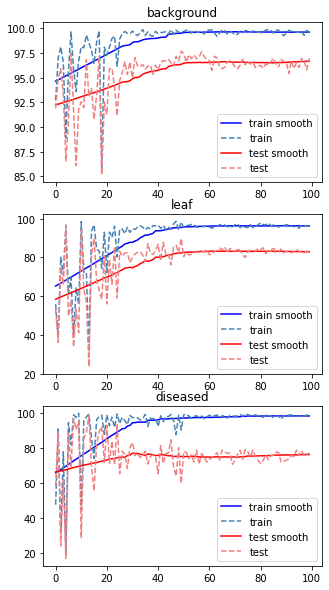

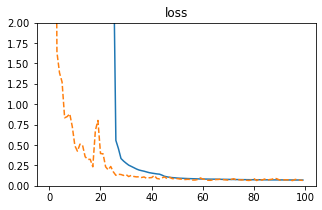

In [34]:
epochs = [e for e in range(num_epochs)]

plt.figure(figsize=(5, 10))
for i in range(num_classes):
    ax = plt.subplot(311 + i)
    ax.set_title(classes[i])
    ax.plot(epochs, smooth_h_train[5 + i], 'blue', label='train smooth')
    ax.plot(epochs, history_train[5 + i], 'steelblue', linestyle='dashed', label='train')

    ax.plot(epochs, smooth_h_test[5 + i], 'red', label='test smooth')
    ax.plot(epochs, history_test[5 + i], 'lightcoral', linestyle='dashed', label='test')
    ax.legend(loc='lower right')

plt.figure(figsize=(5, 3))    
plt.plot(epochs, smooth_h_train[5 + num_classes], label='train smooth')
plt.plot(epochs, history_train[5 + num_classes], linestyle='dashed', label='train')   
plt.ylim(0, 2)
plt.title("loss")

In [ ]:
# fig.savefig('evaluation2.png')

In [33]:
torch.save(model.state_dict(), os.getcwd() + "\\ResNet_rgb_25_노균병_100.pt")

In [44]:
# Load weights

model.load_state_dict(torch.load(os.getcwd() + "\\ResNet_rgb_25_노균병_best.pt"))

<All keys matched successfully>

In [103]:
# Predict 
def predictDataset(loader, model, display=False):
    actual = np.array([])
    prediction = np.array([])
    display_count = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            actual = np.append(actual, y.cpu().detach().numpy())
            prediction = np.append(prediction, predictions.cpu().detach().numpy())
            if display and display_count == 0:
                displayImgs(x, prediction.astype(int), img_size, save=True)
                display_count += 1
    model.train()
    
    return actual, prediction

In [48]:
train_dataset_ori = Img(img_df=train_patch, transform=img_transform)
val_dataset_ori = Img(img_df=val_patch, transform=img_transform)

train_loader_ori = DataLoader(dataset=train_dataset_ori, batch_size=batch_size, shuffle=True)
test_loader_ori = DataLoader(dataset=val_dataset_ori, batch_size=batch_size, shuffle=True)

ds_all_ori = DataLoader(dataset=ConcatDataset([train_dataset_ori, val_dataset_ori]), 
                        batch_size=batch_size, shuffle=True)

ds_all = DataLoader(dataset=ConcatDataset([train_dataset, val_dataset]), 
           batch_size=batch_size, shuffle=True)

In [49]:
actual_test_ori, prediction_test_ori = predictDataset(test_loader_ori, model)
actual_all_ori, prediction_all_ori = predictDataset(ds_all_ori, model)

actual_test, prediction_test = predictDataset(test_loader, model)
actual_all, prediction_all = predictDataset(ds_all, model)

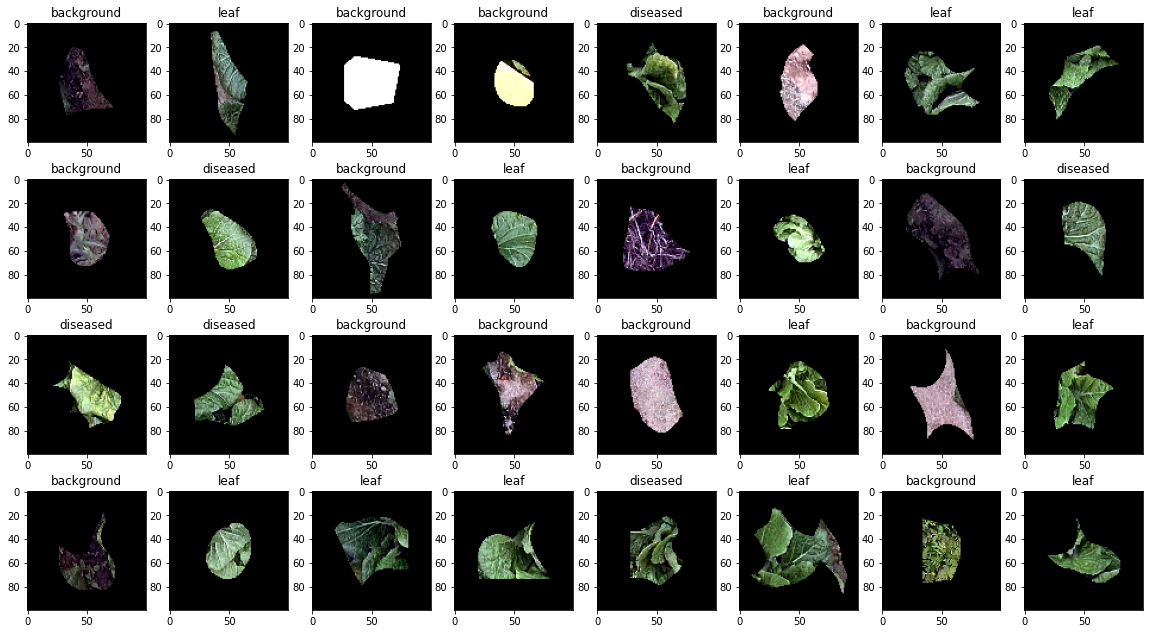

In [104]:
actual_test_ori, prediction_test_ori = predictDataset(test_loader_ori, model, display=True)

In [52]:
def drawConfusionMatrix(actual, prediction, normalize=True, savefig=False):
    confusion_matrix = metrics.confusion_matrix(actual, prediction)
    cmn = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    
    if normalize:
        confusion_matrix = cmn
    
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["0", "1", "2"])
    cm_display.plot()
    plt.show()
    
    if savefig:
        plt.savefig('confusion_matrix.png')

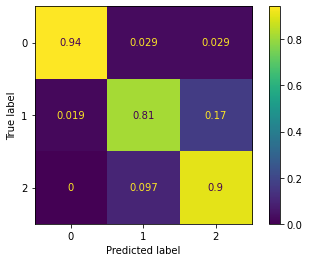

In [53]:
drawConfusionMatrix(actual_test_ori, prediction_test_ori, normalize=True)

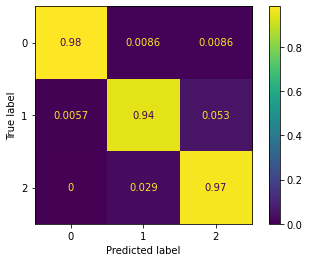

In [54]:
drawConfusionMatrix(actual_all_ori, prediction_all_ori, normalize=True)

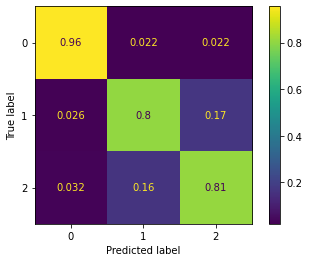

In [55]:
drawConfusionMatrix(actual_test, prediction_test, normalize=True)

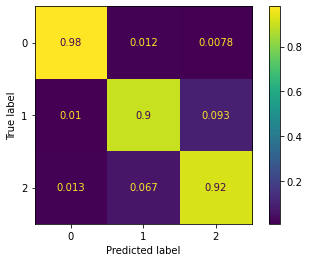

In [56]:
drawConfusionMatrix(actual_all, prediction_all, normalize=True)